In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Insurity_Assignement/driving_data_large.csv")

In [ ]:
data.head()

,driver_id,trip_id,timestamp,latitude,longitude,speed_kmh,accelerometer_x,accelerometer_y,accelerometer_z
0,driver_safe_01,trip_f591bff5-33ce-497d-8bbb-d1fc8d31be77,2025-05-30 16:38:43.277572,40.712753,-74.006106,57.12,-0.6880,-0.3066,9.8
1,driver_safe_01,trip_f591bff5-33ce-497d-8bbb-d1fc8d31be77,2025-05-30 16:38:44.277572,40.712862,-74.006205,45.84,-0.3554,-0.2550,9.8
2,driver_safe_01,trip_f591bff5-33ce-497d-8bbb-d1fc8d31be77,2025-05-30 16:38:45.277572,40.712741,-74.006175,50.14,-0.7210,-0.6155,9.8
3,driver_safe_01,trip_f591bff5-33ce-497d-8bbb-d1fc8d31be77,2025-05-30 16:38:46.277572,40.712762,-74.006270,49.73,0.2490,-0.1084,9.8
4,driver_safe_01,trip_f591bff5-33ce-497d-8bbb-d1fc8d31be77,2025-05-30 16:38:47.277572,40.712714,-74.006270,42.35,0.4324,0.5786,9.8


In [ ]:
data.shape

(249420, 9)

In [ ]:
data.dtypes

,0
driver_id,object
trip_id,object
timestamp,object
latitude,float64
longitude,float64
speed_kmh,float64
accelerometer_x,float64
accelerometer_y,float64
accelerometer_z,float64


In [ ]:
#Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249420 entries, 0 to 249419
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   driver_id        249420 non-null  object        
 1   trip_id          249420 non-null  object        
 2   timestamp        249420 non-null  datetime64[ns]
 3   latitude         249420 non-null  float64       
 4   longitude        249420 non-null  float64       
 5   speed_kmh        249420 non-null  float64       
 6   accelerometer_x  249420 non-null  float64       
 7   accelerometer_y  249420 non-null  float64       
 8   accelerometer_z  249420 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 17.1+ MB


# **Feature Engineering**

In [ ]:
#Define thresholds for feature Engineering
#These thresholds define what we define as a "risky" event
#These values are common starting points and can be fine-tuned

HARSH_ACCELERATION_THRESHOLD = 2.5 # m/s^2
HARSH_BRAKING_THRESHOLD = -2.5   # m/s^2 (negative for deceleration)
HARSH_TURNING_THRESHOLD = 2.0   # m/s^2 (lateral G-force)
SPEEDING_THRESHOLD = 90         # km/h

In [ ]:
# We will group by trip_id and calculate features for each trip
# Calculate total magnitude of acceleration for turning
data['lateral_accel_mag'] = data['accelerometer_y'].abs()

In [ ]:
# Group by trip_id
grouped = data.groupby('trip_id')

In [ ]:
grouped

In [ ]:
features_list = []

for trip_id, trip_df in grouped:
    # Basic trip info
    driver_id = trip_df['driver_id'].iloc[0]
    trip_duration_seconds = (trip_df['timestamp'].max() - trip_df['timestamp'].min()).total_seconds()

    # Feature: Count of Harsh Events
    harsh_accelerations = (trip_df['accelerometer_x'] > HARSH_ACCELERATION_THRESHOLD).sum()
    harsh_brakings = (trip_df['accelerometer_x'] < HARSH_BRAKING_THRESHOLD).sum()
    harsh_turnings = (trip_df['lateral_accel_mag'] > HARSH_TURNING_THRESHOLD).sum()

    # Feature: Percentage of time speeding
    speeding_duration_seconds = trip_df[trip_df['speed_kmh'] > SPEEDING_THRESHOLD].shape[0]
    percent_time_speeding = (speeding_duration_seconds / trip_duration_seconds) * 100 if trip_duration_seconds > 0 else 0

    # Feature: Total Trip Distance (Mileage)
    # Calculated by summing up the distance traveled each second
    trip_distance_km = (trip_df['speed_kmh'] * (1/3600)).sum() # Speed is in km/h, time interval is 1 sec (1/3600 h)

    # Feature: Driving in Risky Hours (e.g., 10 PM to 5 AM)
    risky_hours_count = trip_df[trip_df['timestamp'].dt.hour.isin([22, 23, 0, 1, 2, 3, 4])].shape[0]
    percent_time_risky_hours = (risky_hours_count / trip_duration_seconds) * 100 if trip_duration_seconds > 0 else 0

    features_list.append({
        'trip_id': trip_id,
        'driver_id': driver_id,
        'trip_duration_s': trip_duration_seconds,
        'trip_distance_km': trip_distance_km,
        'harsh_accelerations': harsh_accelerations,
        'harsh_brakings': harsh_brakings,
        'harsh_turnings': harsh_turnings,
        'percent_time_speeding': percent_time_speeding,
        'percent_time_risky_hours': percent_time_risky_hours
    })

In [ ]:
#Create the final features dataframe
features_df = pd.DataFrame(features_list)

In [ ]:
features_df.shape

(100, 9)

In [ ]:
features_df.head()

,trip_id,driver_id,trip_duration_s,trip_distance_km,harsh_accelerations,harsh_brakings,harsh_turnings,percent_time_speeding,percent_time_risky_hours
0,trip_01c68640-32fc-4c09-a063-d3899d277371,driver_risky_04,2699.0,52.815369,19,24,151,9.373842,0.0
1,trip_066838c2-252d-4739-b5a5-bf607846ebbc,driver_safe_01,1919.0,23.973014,0,0,0,0.000000,0.0
2,trip_0badcd70-b376-47d6-957d-ea6d538b4d06,driver_safe_02,1679.0,20.934486,0,0,0,0.000000,0.0
3,trip_1076a852-4f4b-40bc-ace3-c735997d1adf,driver_risky_04,1739.0,33.838175,18,13,88,8.740656,0.0
4,trip_11207115-d64b-4ed1-b865-8e59d7fceae6,driver_safe_03,1499.0,18.743256,0,0,0,0.000000,0.0


**Visualizations**

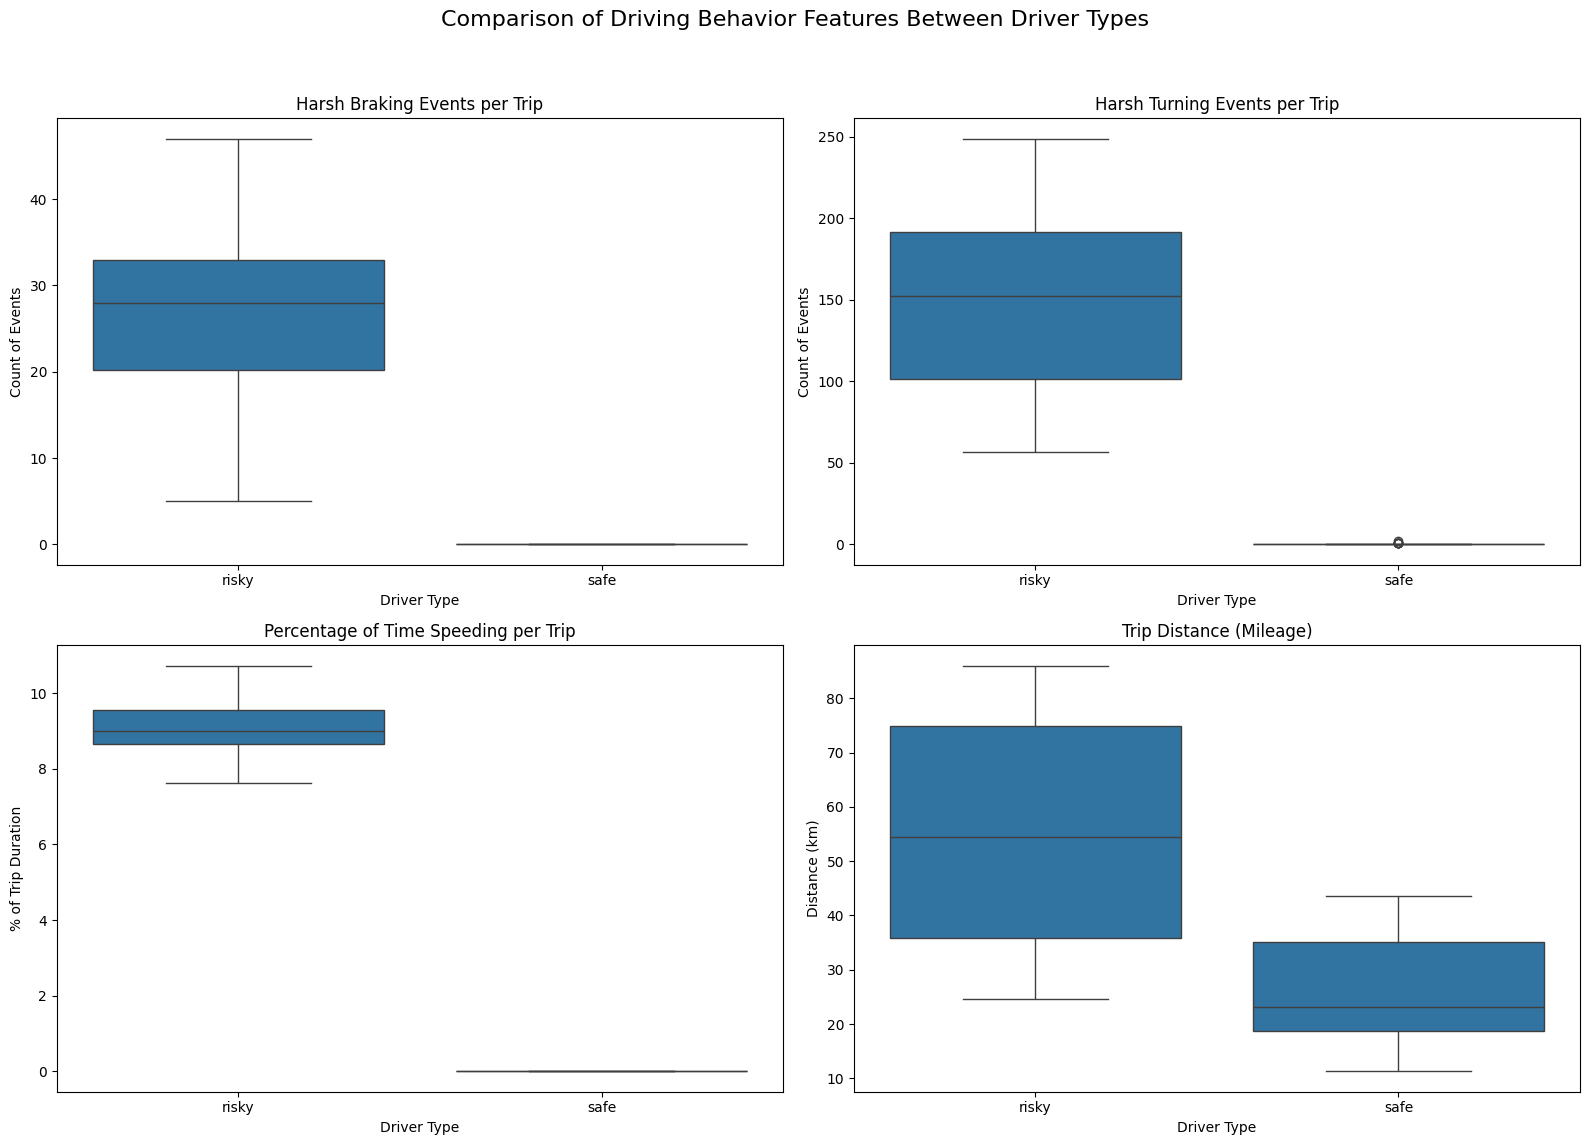

In [ ]:
# Add a 'driver_type' column for easier plotting
features_df['driver_type'] = features_df['driver_id'].apply(lambda x: 'risky' if 'risky' in x else 'safe')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparison of Driving Behavior Features Between Driver Types', fontsize=16)

# Plot 1: Harsh Braking
sns.boxplot(ax=axes[0, 0], x='driver_type', y='harsh_brakings', data=features_df)
axes[0, 0].set_title('Harsh Braking Events per Trip')
axes[0, 0].set_xlabel('Driver Type')
axes[0, 0].set_ylabel('Count of Events')

# Plot 2: Harsh Turning
sns.boxplot(ax=axes[0, 1], x='driver_type', y='harsh_turnings', data=features_df)
axes[0, 1].set_title('Harsh Turning Events per Trip')
axes[0, 1].set_xlabel('Driver Type')
axes[0, 1].set_ylabel('Count of Events')

# Plot 3: Speeding
sns.boxplot(ax=axes[1, 0], x='driver_type', y='percent_time_speeding', data=features_df)
axes[1, 0].set_title('Percentage of Time Speeding per Trip')
axes[1, 0].set_xlabel('Driver Type')
axes[1, 0].set_ylabel('% of Trip Duration')

# Plot 4: Trip Distance
sns.boxplot(ax=axes[1, 1], x='driver_type', y='trip_distance_km', data=features_df)
axes[1, 1].set_title('Trip Distance (Mileage)')
axes[1, 1].set_xlabel('Driver Type')
axes[1, 1].set_ylabel('Distance (km)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Based on the plots comparing the driving behavior features between 'risky' and 'safe' drivers, here's an analysis of what each plot shows:

**1) Harsh Braking Events per Trip:** The box plot clearly shows that 'risky' drivers have a significantly higher number of harsh braking events per trip compared to 'safe' drivers. The median, upper quartile, and maximum values are all considerably higher for the 'risky' group.

**2) Harsh Turning Events per Trip:** Similar to harsh braking, the plot for harsh turning events indicates that 'risky' drivers exhibit more harsh turning instances during their trips than 'safe' drivers.

**3) Percentage of Time Speeding per Trip:** The box plot for speeding shows that 'risky' drivers spend a higher percentage of their trip duration exceeding the speed limit compared to 'safe' drivers.

**4) Trip Distance (Mileage):** This plot appears to show that 'risky' drivers tend to have longer trips (higher mileage) than 'safe' drivers. While not a direct measure of risky behavior, longer trips could potentially expose drivers to more opportunities for risky events, or it could simply be a characteristic of the 'risky' driver group in this dataset.

All these observations validate our feature engineering process as these were the initial assumptions we started with.

In [ ]:
# Save the features to a new CSV file
features_df.to_csv('trip_summary_features.csv', index=False)
print("\nTrip summary features saved to 'trip_summary_features.csv'")


Trip summary features saved to 'trip_summary_features.csv'


# **Building the risk Scoring model**

Here, we take an approach of start training with some fundamental machine learning models and then observe the results, based on which we make modifications to our final choice of model.

We will start with Linear Regression and Random Forest model as these are the ones mentioned in problem statement and let's see what happens.

In [ ]:
# Define target Variable (Risk Score)
# Now, we have sevearal factors contributing to risk score like harsh braking, harsh turning, speeding and trip distance.
# We need to give certain weights to all these features to calculate risk score.
# For PoC(Proof of Concept) and lower complexiety, we just manually define the weights for each of these features with our intuition.
# Trip distance would actually not contribute much to rosk score as compared to harsh braking and speedding.
# Trip distance is there to basically for modelling PAYD.

weights = {
    'harsh_accelerations': 2.0,
    'harsh_brakings': 3.0,      # Most heavily weighted
    'harsh_turnings': 2.5,
    'percent_time_speeding': 2.0,
    'percent_time_risky_hours': 1.0
}

In [ ]:
# Calculate the risk score for each trip
features_df['risk_score'] = (
    features_df['harsh_accelerations'] * weights['harsh_accelerations'] +
    features_df['harsh_brakings'] * weights['harsh_brakings'] +
    features_df['harsh_turnings'] * weights['harsh_turnings'] +
    features_df['percent_time_speeding'] * weights['percent_time_speeding'] +
    features_df['percent_time_risky_hours'] * weights['percent_time_risky_hours']
)

In [ ]:
# Normalize the score to be roughly between 0 and 100 for easier interpretation
features_df['risk_score'] = 100 * (features_df['risk_score'] / features_df['risk_score'].max())

In [ ]:
print(features_df[['driver_id','trip_id', 'risk_score']].head())

         driver_id                                    trip_id  risk_score
0  driver_risky_04  trip_01c68640-32fc-4c09-a063-d3899d277371   60.165017
1   driver_safe_01  trip_066838c2-252d-4739-b5a5-bf607846ebbc    0.000000
2   driver_safe_02  trip_0badcd70-b376-47d6-957d-ea6d538b4d06    0.000000
3  driver_risky_04  trip_1076a852-4f4b-40bc-ace3-c735997d1adf   37.136848
4   driver_safe_03  trip_11207115-d64b-4ed1-b865-8e59d7fceae6    0.000000


 **Note**: This is the basic approach for PoC and lower complexiety. In real applications, we can seperately train a machine learning model like Logistic Regression or Gradient Boosting on a historical dataset having risk scores and all these features like harsh braking, speeding etc. Then we use the weights so obtained in this step.
 The advantage of this approach is that we can go beyond just human guesses and identify hidden relations between risk scores and these features. The results so obtained will be statistical

 However, I avoid this approach here becuase of limited compute resources, limited time and most importantly for keeping the model simpler. We will also need a huge corpus of historical data which can again be a challenge to collect.

**Prepare Data for modelling**

In [ ]:
from sklearn.model_selection import train_test_split

# Define our features (X) and our target (y)
X = features_df[['harsh_accelerations', 'harsh_brakings', 'harsh_turnings',
                 'percent_time_speeding', 'percent_time_risky_hours']]
y = features_df['risk_score']

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Modelling**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Model 1: Linear Regression (a simple, interpretable baseline)
print("\n--- Training Linear Regression Model ---")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Evaluate Linear Regression
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)
print(f"Linear Regression - Mean Absolute Error: {lr_mae:.2f}")
print(f"Linear Regression - R-squared: {lr_r2:.2f}")



--- Training Linear Regression Model ---
Linear Regression - Mean Absolute Error: 0.00
Linear Regression - R-squared: 1.00


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Model 2: Random Forest Regressor (a more powerful, complex model)
print("\n--- Training Random Forest Model ---")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Evaluate Random Forest
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest - Mean Absolute Error: {rf_mae:.2f}")
print(f"Random Forest - R-squared: {rf_r2:.2f}")


--- Training Random Forest Model ---
Random Forest - Mean Absolute Error: 0.67
Random Forest - R-squared: 1.00


In [ ]:
# --- 6. Evaluation on NOISY Data (Robustness Test) ---
print("\n--- Evaluating on NOISY Test Data ---")
# Create a noisy version of the test data
X_test_noisy = X_test.copy()
NOISE_LEVEL = 0.10
for column in X_test_noisy.columns:
    if X_test_noisy[column].std() > 0:
        noise = np.random.normal(0, X_test_noisy[column].std() * NOISE_LEVEL, X_test_noisy.shape[0])
        X_test_noisy[column] += noise
# Make predictions on the noisy data
lr_preds_noisy = lr_model.predict(X_test_noisy)
rf_preds_noisy = rf_model.predict(X_test_noisy)

# Evaluate performance
lr_r2_noisy = r2_score(y_test, lr_preds_noisy)
rf_r2_noisy = r2_score(y_test, rf_preds_noisy)
lr_mae_noisy = mean_absolute_error(y_test, lr_preds_noisy)
rf_mae_noisy = mean_absolute_error(y_test, rf_preds_noisy)

print(f"Linear Regression (Noisy) - R-squared: {lr_r2_noisy:.2f}, MAE: {lr_mae_noisy:.2f}")
print(f"Random Forest (Noisy)     - R-squared: {rf_r2_noisy:.2f}, MAE: {rf_mae_noisy:.2f}")


--- Evaluating on NOISY Test Data ---
Linear Regression (Noisy) - R-squared: 0.99, MAE: 1.84
Random Forest (Noisy)     - R-squared: 1.00, MAE: 0.63


In [ ]:
import joblib
# Save the winning model
model_filename = 'risk_model.joblib'
joblib.dump(rf_model, model_filename)

['risk_model.joblib']